1. Выберите одну из зон среди отобранных на прошлой неделе, возьмите по ней все подготовленные данные о количестве поездок. Не используйте данные за последний имеющийся месяц — июнь 2016! Создайте регрессионные признаки для учёта сезонностей и трендов.
2. Чтобы примерно подобрать порядки дифференцирования ряда в модели ARIMA, сделайте регрессию целевого признака — количества поездок — на построенные признаки. Посмотрите на остатки регрессии. Если регрессионные признаки подобраны идеально, то в них должна остаться только внутрисуточная сезонность. Вслепую идеально подобрать признаки вам вряд ли удастся, так что в остатках вы, скорее всего, увидите много интересного, в том числе праздники, аномалии, тренды и многое другое.
3. Чтобы подобрать значения гиперпараметров ARIMA, попробуйте сделать ряд остатков стационарным. Если необходимо, сделайте несколько дифференцирований. Из-за большого количества аномальных дней (праздники и т.д.) вряд ли вам удастся сделать так, что критерий Дики-Фуллера не будет отвергать гипотезу нестационарности, поэтому при выборе порядка дифференцирования ориентируйтесь в первую очередь на результат STL-декомпозиции.
4. Постройте ACF и PACF полученного ряда остатков (возможно, продифференцированных) с максимальным лагом не меньше длины самого длинного сезонного периода (неделя или год), подберите по ним начальные приближения для параметров p, q, P, Qp,q,P,Q. Используйте эти начальные приближения при переборе моделей ARIMA исходного ряда, не забывая подавать функции SARIMAX регрессионные признаки в качестве параметра exog.
5. Выберите оптимальную по AIC модель; постройте график исходного ряда и нарисуйте поверх предсказания выбранной модели. Если модель плохо описывает данные, попробуйте увеличить количество синусов и косинусов KK или поменять порядки дифференцирования.
6. Проанализируйте качество построенной модели. Опишите, в какие периоды она плохо описывает данные? Можно ли заранее предсказать её поведение в такие периоды и улучшить тем самым прогноз? Если да, попробуйте создать для таких периодов регрессионные признаки и вернитесь к пункту 2.
7. Загрузите ноутбук в форму.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from datetime import datetime
import requests
from io import BytesIO
import pickle
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from sklearn.linear_model import LinearRegression
import math
import warnings
from pylab import rcParams
from sklearn.base import BaseEstimator, TransformerMixin
warnings.filterwarnings('ignore')
# Register converters to avoid warnings
pd.plotting.register_matplotlib_converters()
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
with open('regions_week2.pkl', 'rb') as file:
    regions = pickle.load(file)

In [3]:
# with open("region_1283.pkl", "rb") as fid:
#     data_d = pickle.load(fid, encoding='latin1')
# df = data_d
# df.info()

In [4]:
with open("region_1128.pkl", "rb") as fid:
    data = pickle.load(fid, encoding='latin1')

p = pd.date_range('2014 Jan 1 00:00:00', periods = data.size, freq = 'h')

df = pd.DataFrame(data, columns = ['val'], index=[p])
df.columns = ['trips']
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 21168 entries, (Timestamp('2014-01-01 00:00:00', freq='H'),) to (Timestamp('2016-05-31 23:00:00', freq='H'),)
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   trips   21168 non-null  float64
dtypes: float64(1)
memory usage: 372.1 KB


In [5]:
df.head()

,trips
2014-01-01 00:00:00,799.0
2014-01-01 01:00:00,635.0
2014-01-01 02:00:00,499.0
2014-01-01 03:00:00,370.0
2014-01-01 04:00:00,319.0


In [6]:
#df = df.T
df.columns = ['trips']

Визуализация количества поездок. Данные выбраны для периода с 2015-04-01 00:00:00+00:00 to 2016-04-30 23:00:00+00:00. Январь 2016 дублирует данные декабря 2015, так как данные за январь "кривые" и постоянно вылает обработчик с ошибками.

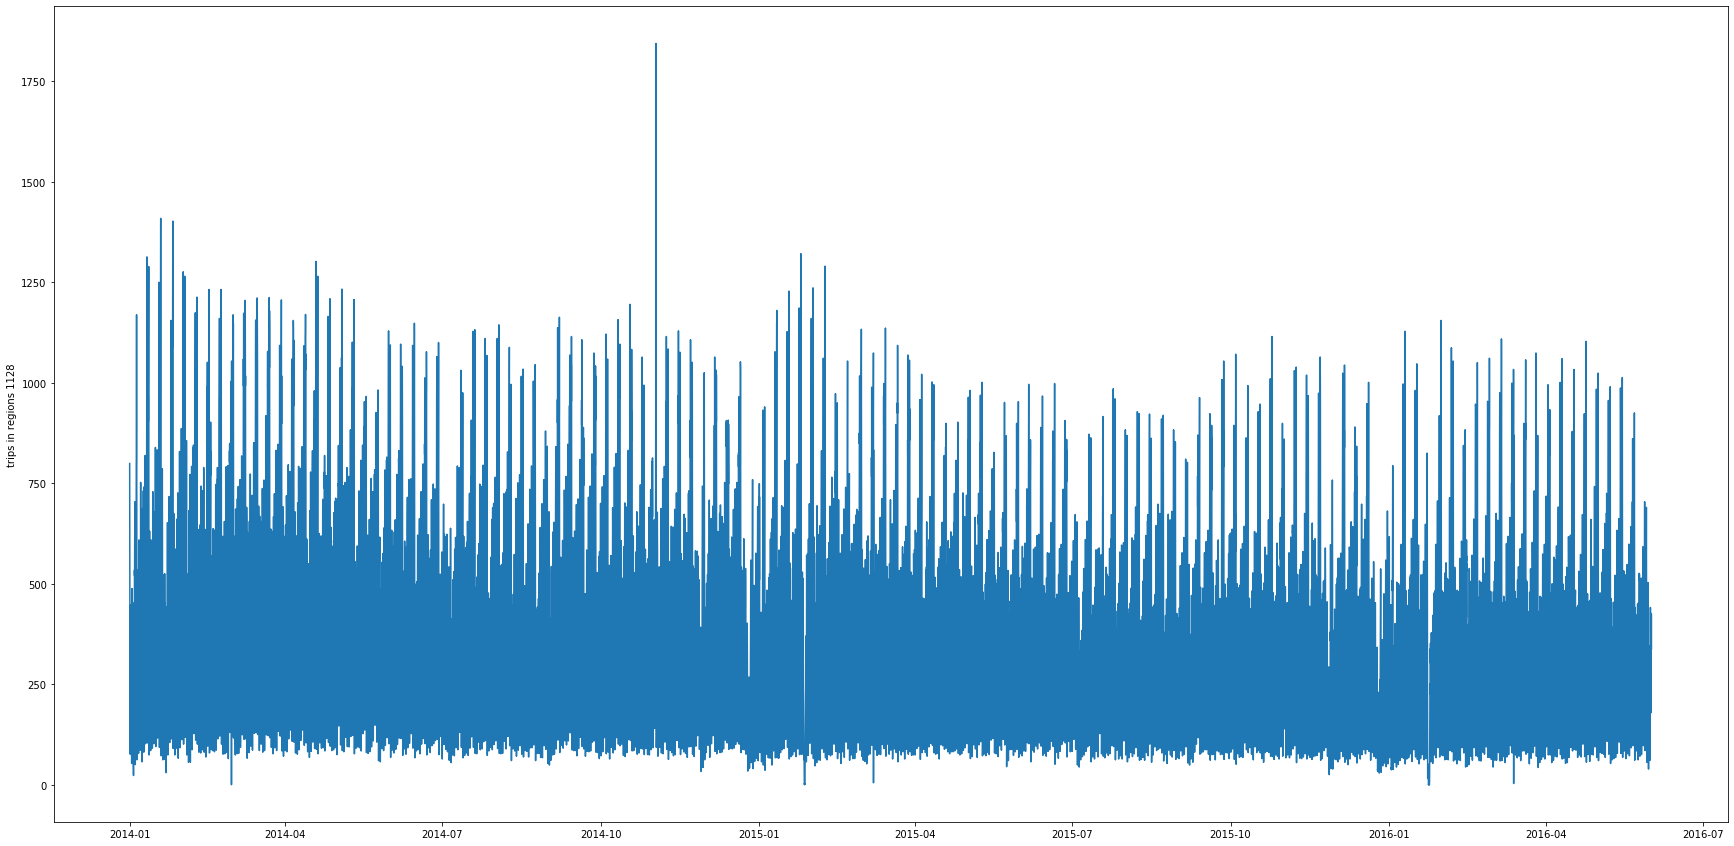

In [7]:
plt.figure(figsize=(30,15))
plt.plot(df)
plt.ylabel('trips in regions 1128')
plt.show()

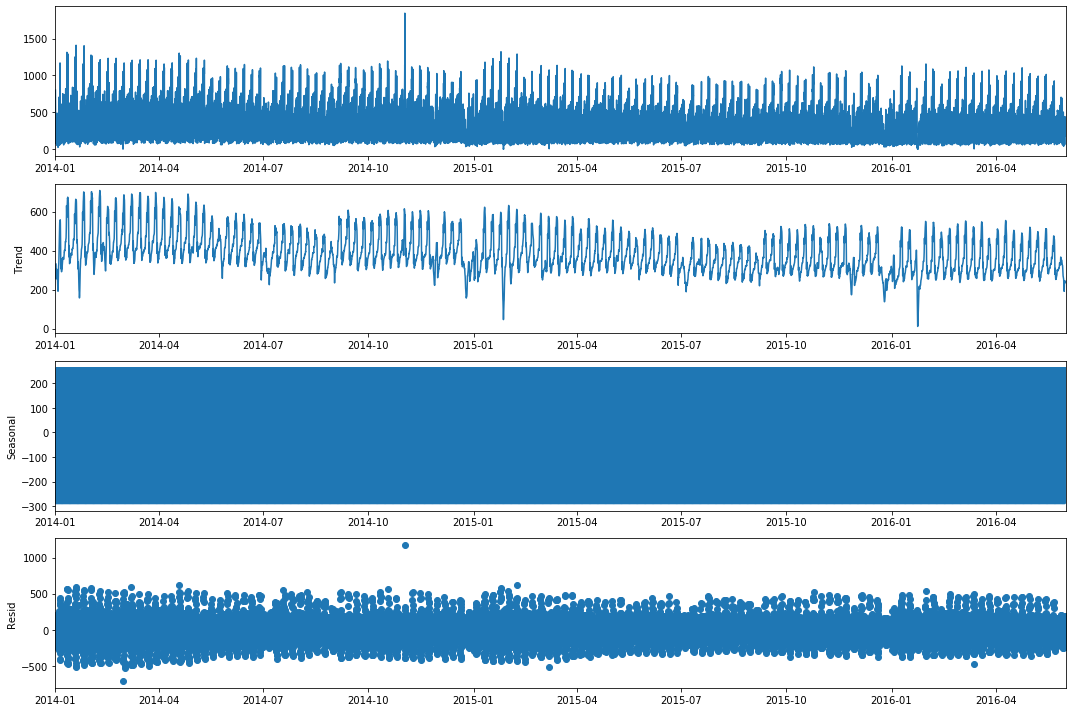

In [8]:
# plt.figure(figsize=(50,10))
# sm.tsa.seasonal_decompose(df, freq=24).plot();
# plt.show()

rcParams['figure.figsize'] = 15, 10
res = sm.tsa.seasonal_decompose(df, freq=24)
fig = res.plot()
plt.show()

In [9]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df)[1])

Критерий Дики-Фуллера: p=0.000000


Модель сезонна и стационарна, значит стабилизация дисперсии не требуется. Но имеется тренд нисходящий.

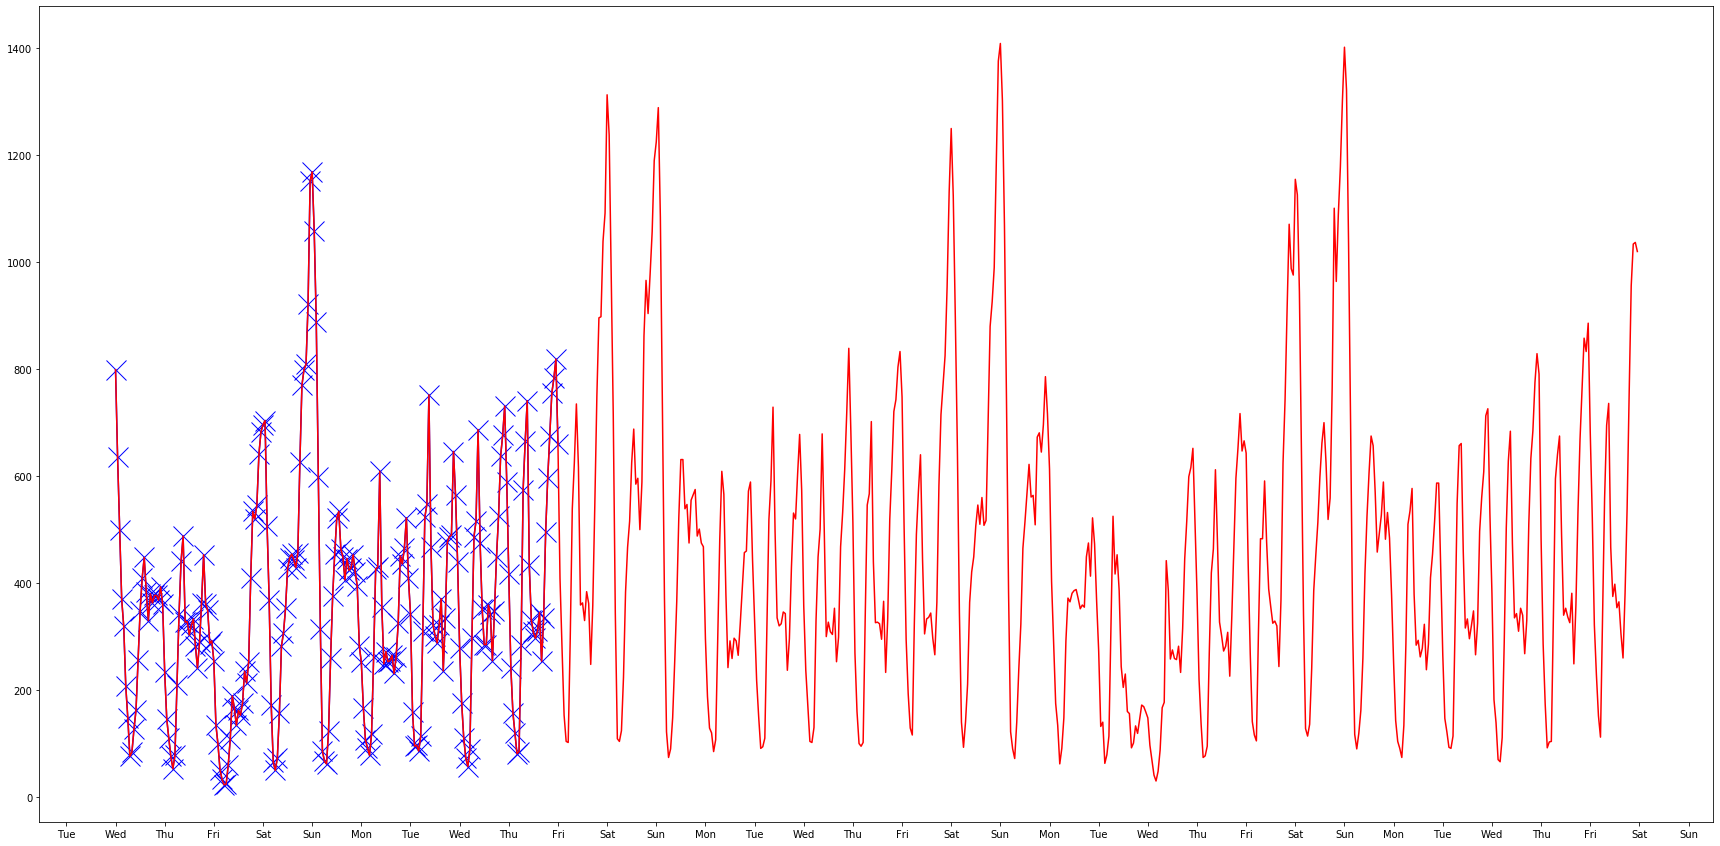

In [10]:
#Модель недели
fig, ax = plt.subplots(figsize=(30,15))
ax.plot(df.trips.head(7*31), color='blue',marker='x',markersize=20)
ax.plot(df.trips.head(24*31), color='red')
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a'))

Нижние пики - ночное время, верхние - дневное. К выходным количество поездок в среднем меньше, но не сильно.

## 3

Далее будем создавать регрессионные признаки в ряд Фурье.

In [12]:
def regression_feats(start,stop,kw=2,ky=0,linear_fe=False):
    #Вспомогательная функция для построения признаков
    
    arg = np.array([x for x in range(start,stop+1)])
    fe_list = []
    columns = []
    #print(arg)
    #Линейный признак для описания простейшего тренда
    if linear_fe:
        fe_list.append(arg) 
        columns.append('t')

    #Признаки для описания недельной сезонности
    for i in range(1,kw+1):
        fe_list.append(np.sin(arg*2*np.pi*i/168))
        columns.append('week_sin_{}'.format(i))
        fe_list.append(np.cos(arg*2*np.pi*i/168))
        columns.append('week_cos_{}'.format(i))
  
    #Признаки для описания годовой сезонности
    for j in range(1,ky+1):
        fe_list.append(np.sin(arg*2*np.pi*j/8766))
        columns.append('year_sin_{}'.format(i))
        fe_list.append(np.cos(arg*2*np.pi*i/8766))
        columns.append('year_cos_{}'.format(i))

    df = pd.DataFrame(fe_list).T
    df.columns = columns
    return df

In [13]:
feachers = regression_feats(1,df.trips.shape[0],20,5)
feachers.head()

,week_sin_1,week_cos_1,week_sin_2,week_cos_2,week_sin_3,week_cos_3,week_sin_4,week_cos_4,week_sin_5,week_cos_5,...,year_sin_20,year_cos_20,year_sin_20,year_cos_20,year_sin_20,year_cos_20,year_sin_20,year_cos_20,year_sin_20,year_cos_20
0,0.037391,0.999301,0.074730,0.997204,0.111964,0.993712,0.149042,0.988831,0.185912,0.982566,...,0.000717,0.999897,0.001434,0.999897,0.002150,0.999897,0.002867,0.999897,0.003584,0.999897
1,0.074730,0.997204,0.149042,0.988831,0.222521,0.974928,0.294755,0.955573,0.365341,0.930874,...,0.001434,0.999589,0.002867,0.999589,0.004301,0.999589,0.005734,0.999589,0.007168,0.999589
2,0.111964,0.993712,0.222521,0.974928,0.330279,0.943883,0.433884,0.900969,0.532032,0.846724,...,0.002150,0.999075,0.004301,0.999075,0.006451,0.999075,0.008601,0.999075,0.010751,0.999075
3,0.149042,0.988831,0.294755,0.955573,0.433884,0.900969,0.563320,0.826239,0.680173,0.733052,...,0.002867,0.998356,0.005734,0.998356,0.008601,0.998356,0.011468,0.998356,0.014335,0.998356
4,0.185912,0.982566,0.365341,0.930874,0.532032,0.846724,0.680173,0.733052,0.804598,0.593820,...,0.003584,0.997432,0.007168,0.997432,0.010751,0.997432,0.014335,0.997432,0.017918,0.997432


In [16]:
model = LinearRegression().fit(feachers,df.trips)
pred_ = model.predict(feachers)
residual = df.trips.values - pred_
resid_df = pd.Series(residual).to_frame(name='residual')

Text(0.5, 1.0, 'residual after regression')

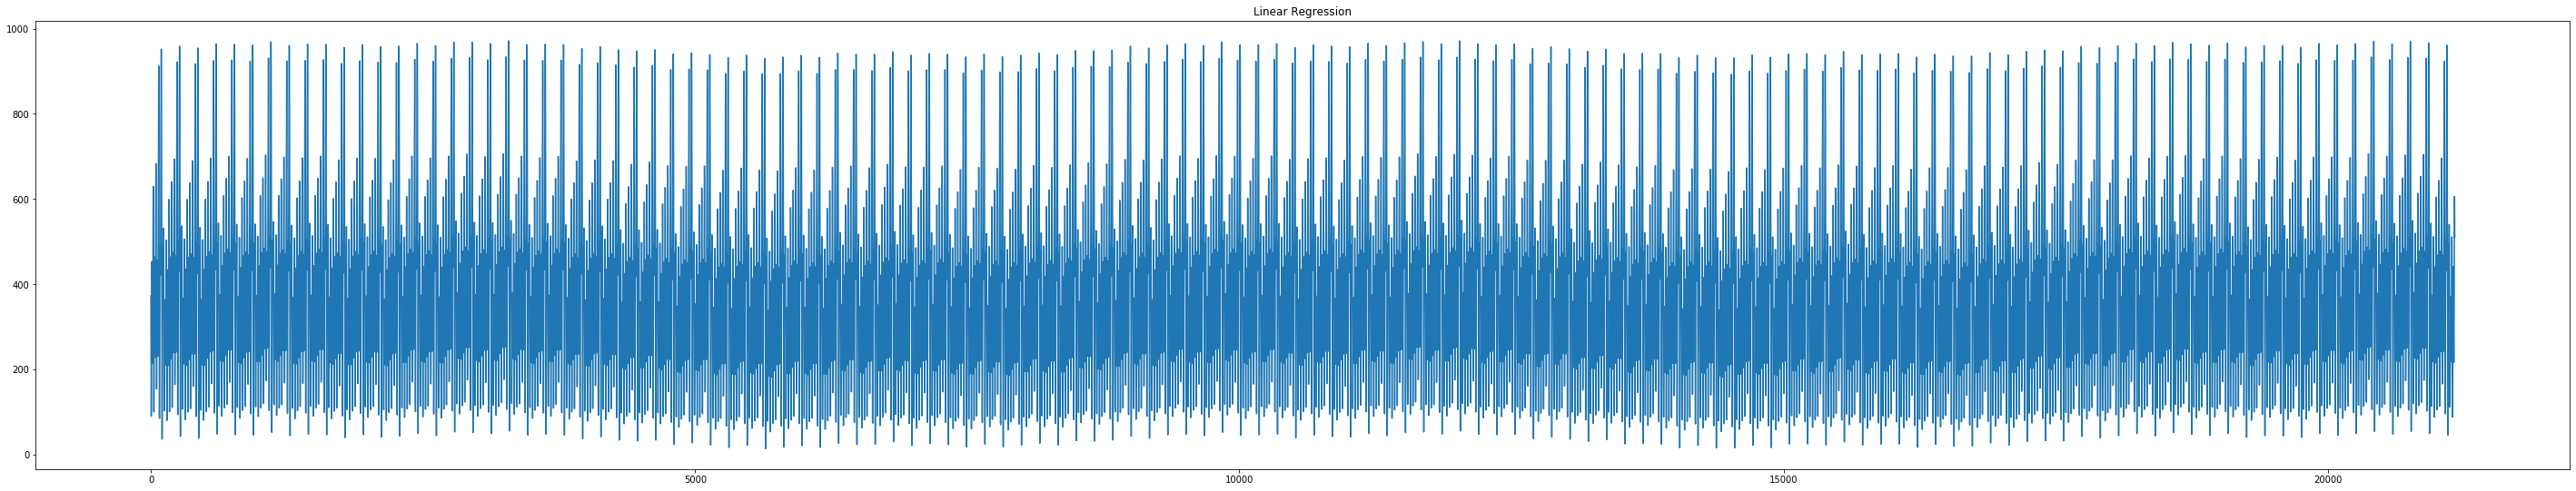

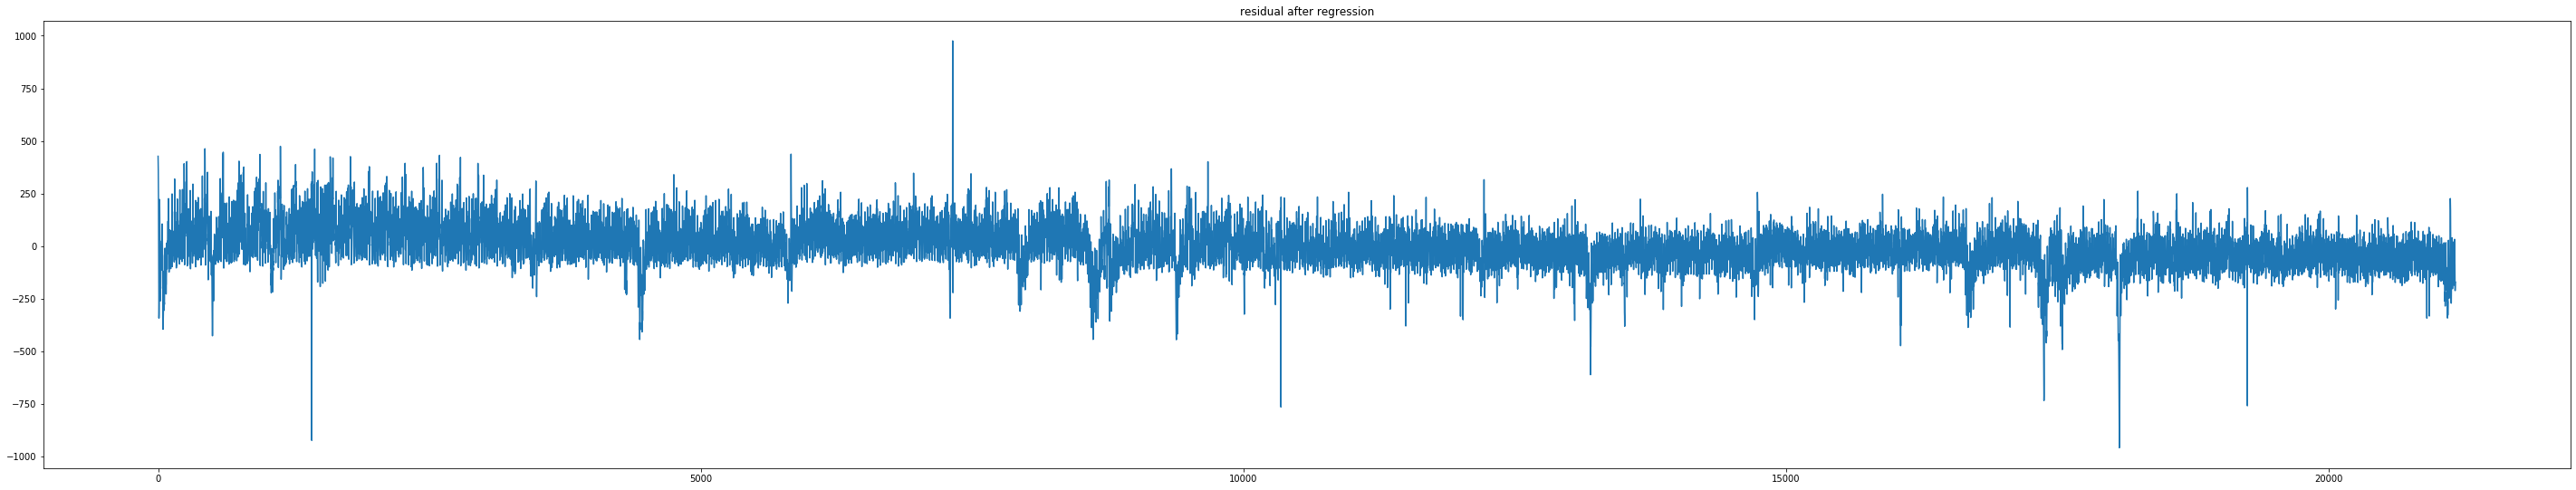

In [17]:
plt.figure(figsize=(50,20))
ax=plt.subplot(211)
ax.plot(pred_)
plt.title('Linear Regression')

plt.figure(figsize=(50,20))
ax1=plt.subplot(212)

ax1.plot(residual)
plt.title('residual after regression')

In [18]:
# fig, ax = plt.subplots(figsize=(30,20))
# ax.plot(pred_, color='red')
# ax.plot(df.trips.values, color='blue')
# ax.xaxis.set_major_locator(mdates.DayLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%a'))
# print('DF criteria: p_value=%f'%sm.tsa.stattools.adfuller(residual)[1])

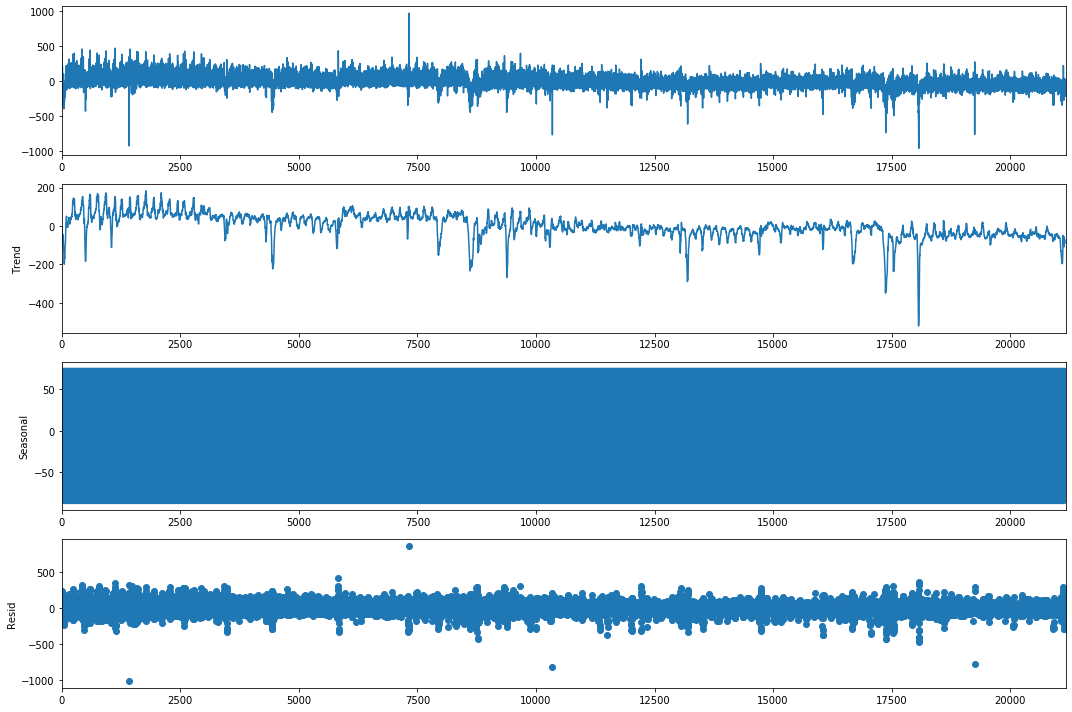

In [19]:
rcParams['figure.figsize'] = 15, 10
res = sm.tsa.seasonal_decompose(resid_df,freq=24)
fig = res.plot()
plt.show()

1.Данные без изменений 
2.Тренд ещё имеется, но уже более плавный
3.Суточная сезонность присутствует и отображается странно
4.resid в пределах нормы

In [20]:
resid_df['diff1'] = resid_df.residual - resid_df.residual.shift(24)
resid_df['diff2'] = resid_df.diff1 - resid_df.diff1.shift(24)
resid_df['diff3'] = resid_df.diff2 - resid_df.diff2.shift(24)
resid_df['diff4'] = resid_df.diff3 - resid_df.diff3.shift(24)
resid_df['diff5'] = resid_df.diff4 - resid_df.diff4.shift(24)

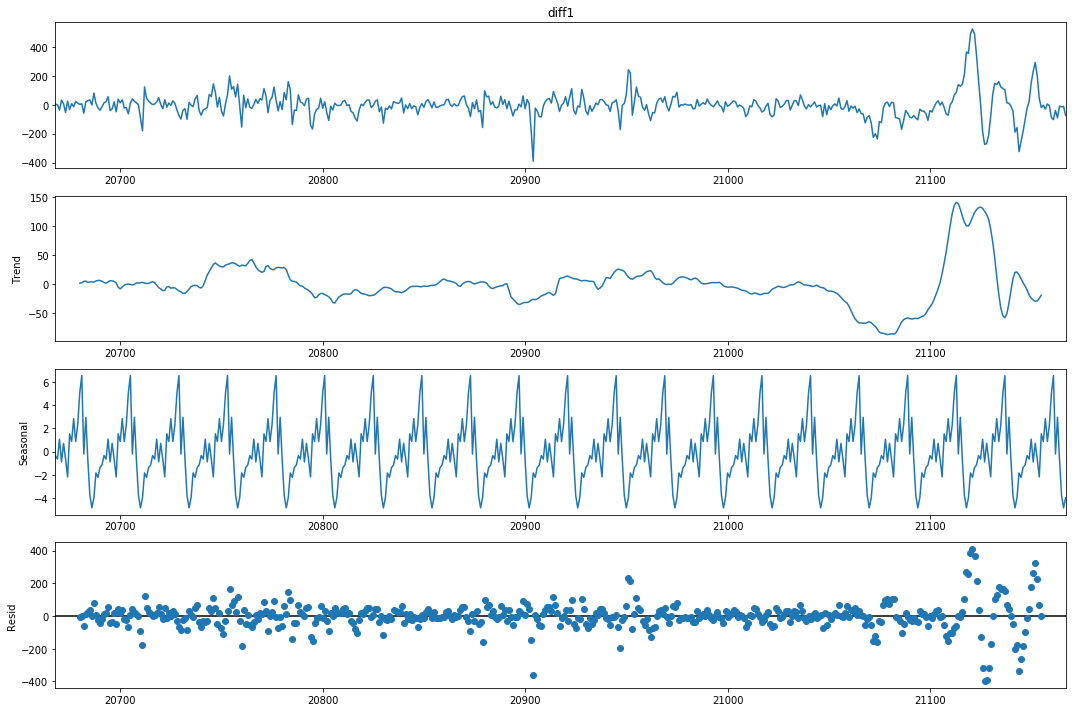

In [21]:
rcParams['figure.figsize'] = 15, 10
res = sm.tsa.seasonal_decompose(resid_df.diff1[-500:],freq=24)
fig = res.plot()
plt.show()

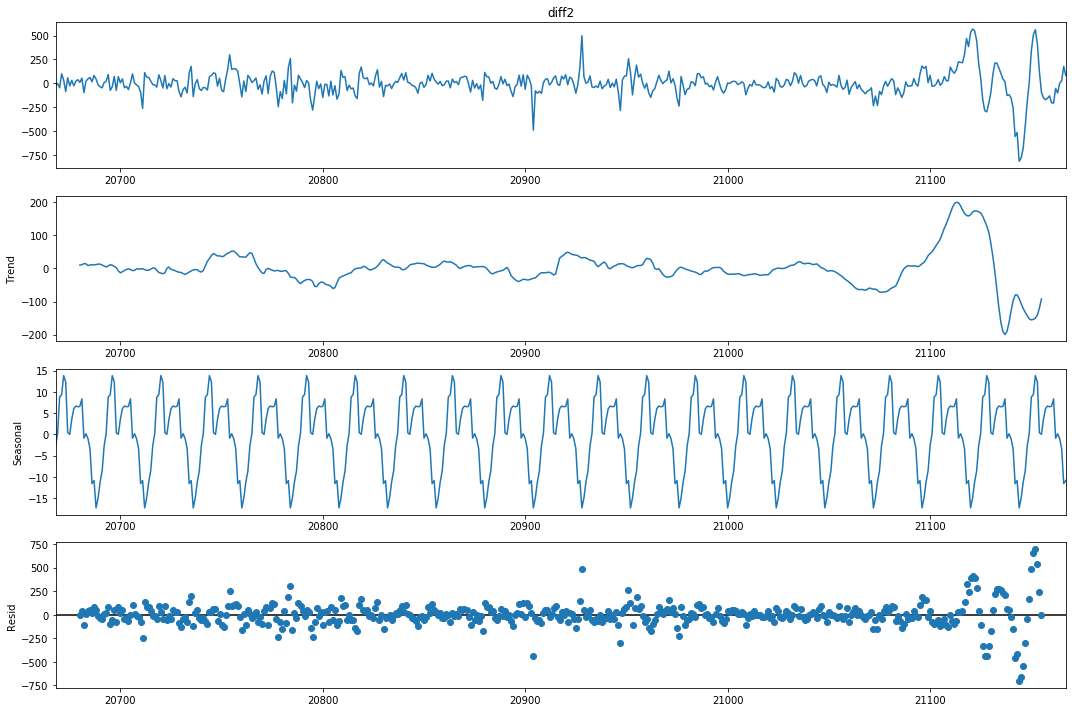

In [22]:
rcParams['figure.figsize'] = 15, 10
res = sm.tsa.seasonal_decompose(resid_df.diff2[-500:],freq=24)
fig = res.plot()
plt.show()

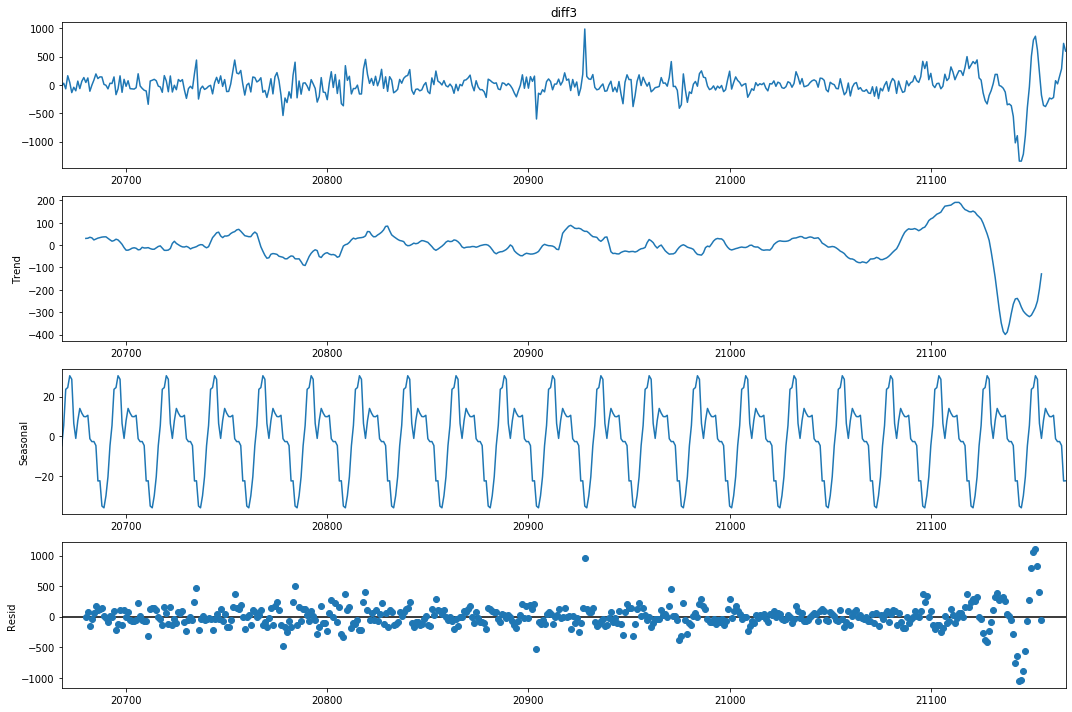

In [23]:
rcParams['figure.figsize'] = 15, 10
res = sm.tsa.seasonal_decompose(resid_df.diff3[-500:],freq=24)
fig = res.plot()
plt.show()

Видимый результат(как и p_value, просто писать не стал, так как он фактически аналогичный предудыщим) дает только первое дифференцирование(4 и 5 не стал выводить, итак много информации, фактически без изменений). За исключением тренда. Но как было сказано в лекциях - нужно меньше дифференцировать, чтобы меньше было расхождение, плэтому остановимся на первом дифференцировании. -500, так как берем последние 500 значений, так как нужно прогнозировать наперед будет.

## 4

Постройте ACF и PACF полученного ряда остатков (возможно, продифференцированных) с максимальным лагом не меньше длины самого длинного сезонного периода (неделя или год), подберите по ним начальные приближения для параметров p, q, P, Qp,q,P,Q. Используйте эти начальные приближения при переборе моделей ARIMA исходного ряда, не забывая подавать функции SARIMAX регрессионные признаки в качестве параметра exog.

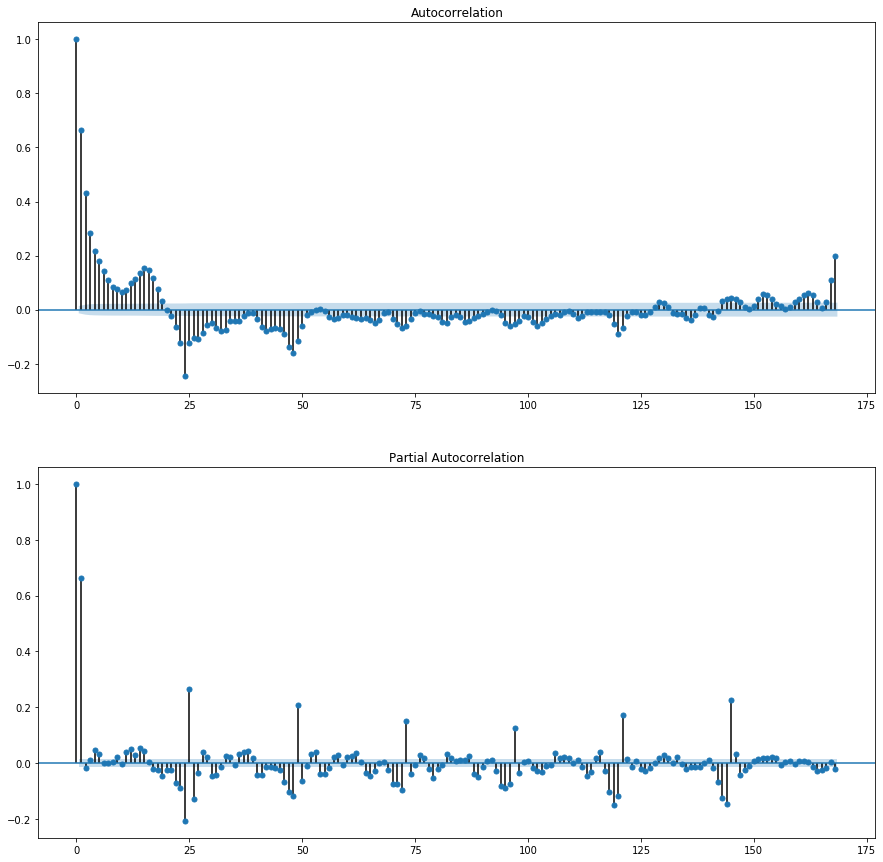

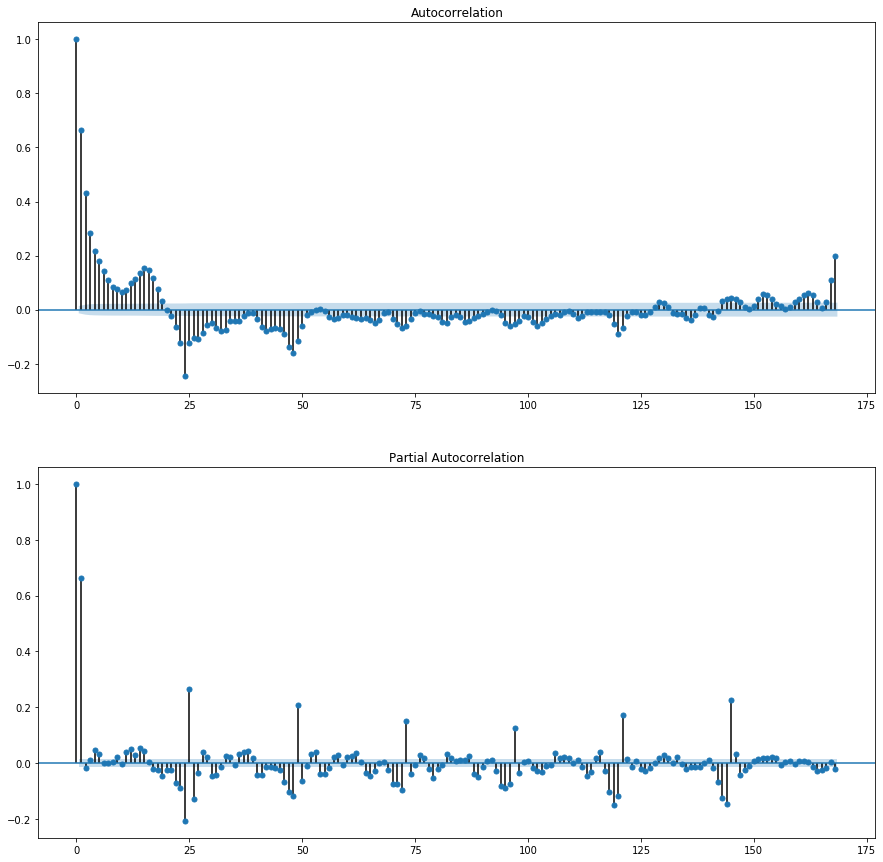

In [24]:
plt.figure(figsize=(15,15))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(resid_df.diff1[25:].values.squeeze(), lags=168,ax=ax)

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(resid_df.diff1[25:].values.squeeze(), lags=168,ax=ax)
#pylab.show()

In [25]:
from itertools import product
# Начальные приближения: Q=1,q=3(то ли 3, то ли 4),p=1,P=1?
ps = range(0, 2)
d=0
qs = range(0, 5)
Ps = range(0, 1)
D=1
Qs = range(0, 1)
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

10

In [26]:
%pylab inline
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [27]:
df_rs=df
df_rs = df_rs[(df_rs.trips > 0)]

In [28]:
for i in range(len(df.trips)):
    if df.trips[i] == 0:
        df.trips[i] = 0.001

In [29]:
ser = pd.Series(df.trips)
df['box'], lmbda = stats.boxcox(ser)

In [31]:
%%time
results = []
best_aic = float("inf")
#warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df.trips,
                                       exog=residual,
                                        order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)
                                       ).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
        
    except ValueError:
        print ('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
#warnings.filterwarnings('default')

Wall time: 8min 22s


In [32]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print (result_table.sort_values(by = 'aic', ascending=True).head())

     parameters            aic
7  (1, 2, 0, 0)  190785.645805
4  (0, 4, 0, 0)  193590.510393
8  (1, 3, 0, 0)  216827.777130
6  (1, 1, 0, 0)  217755.333516
9  (1, 4, 0, 0)  218968.588838


## 5

Лучшие параметры под номером 9.

In [33]:
print (best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               trips   No. Observations:                21168
Model:             SARIMAX(1, 0, 2)x(0, 1, [], 12)   Log Likelihood              -95387.823
Date:                             Fri, 15 May 2020   AIC                         190785.646
Time:                                     15:46:22   BIC                         190825.444
Sample:                                          0   HQIC                        190798.631
                                           - 21168                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0000   1.18e-05   8.45e+04      0.000       1.000       1.000
ar.L1          0.9750      

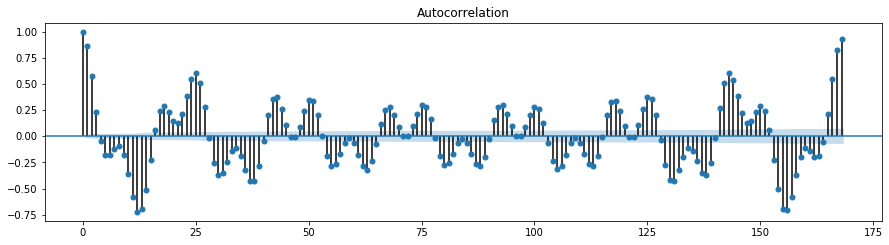

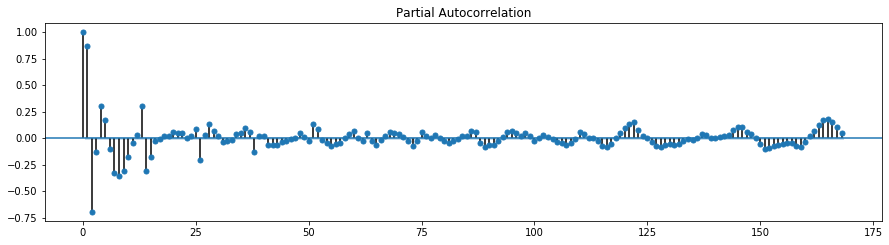

In [34]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=168, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(best_model.resid.values.squeeze(), lags=168, ax=ax)
pylab.show()

In [35]:
print ("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print ("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Критерий Стьюдента: p=0.979197
Критерий Дики-Фуллера: p=0.000000


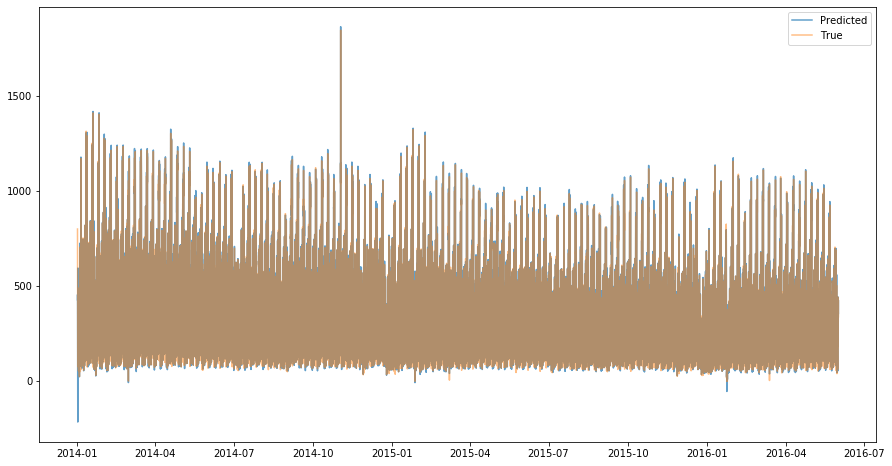

In [36]:
plt.plot(best_model.fittedvalues, alpha = 0.7, label='Predicted')
plt.plot(df.trips, alpha=0.5, label = 'True')
plt.legend()

Модель достаточно неплохо описывает ряд, что говорит о её точности. Есть небольшие выбросы, но это скорее всего аномалии в данных, либо определенные редкие ситуации.

In [43]:
%%time
results = []
best_aic = float("inf")
#warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(residual,
                                       #exog=residual,
                                        order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)
                                       ).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
        
    except ValueError:
        print ('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
#warnings.filterwarnings('default')

Wall time: 56.5 s


In [44]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print (result_table.sort_values(by = 'aic', ascending=True).head())

     parameters            aic
9  (1, 4, 0, 0)  246500.612451
8  (1, 3, 0, 0)  246600.184198
4  (0, 4, 0, 0)  247435.671251
3  (0, 3, 0, 0)  247622.497848
7  (1, 2, 0, 0)  247892.683384


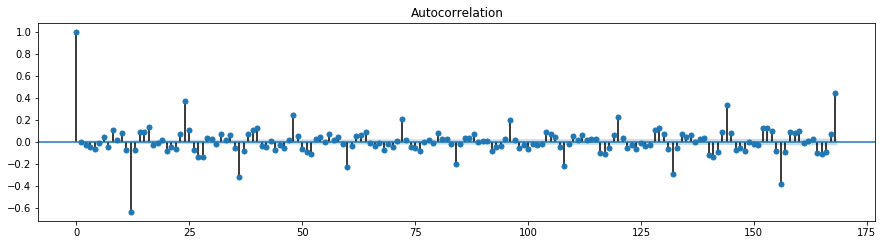

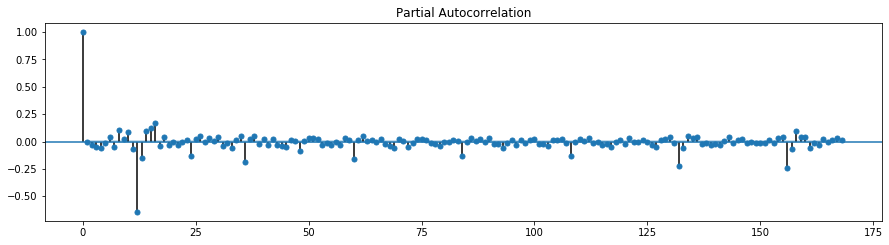

In [46]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(best_model.resid.squeeze(), lags=168, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(best_model.resid.squeeze(), lags=168, ax=ax)
pylab.show()

In [47]:
print ("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print ("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Критерий Стьюдента: p=0.980757
Критерий Дики-Фуллера: p=0.000000


In [51]:
plt.plot(best_model.fittedvalues, alpha = 0.7, label='Predicted')
plt.plot(df.trips, alpha=0.5, label = 'True')
plt.legend()

ValueError: view limit minimum -36805.79791666667 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

In [52]:
plt.plot(best_model.resid[13:], alpha = 0.7, label='Predicted')
plt.plot(df.trips, alpha=0.5, label = 'True')
plt.legend()

ValueError: view limit minimum -36805.79791666667 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units